In [70]:
import psycopg2
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [5]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

In [11]:
conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()


In [20]:
query_olympus = """
select
    date(event_timestamp) as date
    , extract(hour from event_timestamp) as hour
    , cd.advertiser_name
    , cd.app_identifier
    , sum(preload_count) preloads
    , sum(install_count) installs
from venus.event_fact f
join venus.campaign_dimension cd
    on f.campaign_id = cd.campaign_id 
    and cd.billing_type_id = 1
    and cd.bid_price_per_download > 0
where
    date(event_timestamp) >= '2020-07-01'
    and date(event_timestamp) <= '2021-03-08'
group by 1,2,3,4
"""

In [21]:
cur_olympus.execute(query_olympus)
df = pd.DataFrame(cur_olympus.fetchall(), columns = [c[0] for c in cur_olympus.description])
df

date  hour                                advertiser_name  \
0        2020-07-01     0                       PlaySimple Games Pte Ltd   
1        2020-07-01     0                                 TikTok Pte.Ltd   
2        2020-07-01     0                                        Autodoc   
3        2020-07-01     0                 Azur Interactive Games Limited   
4        2020-07-01     0                                         Voodoo   
...             ...   ...                                            ...   
1353671  2021-03-08     3                                         Voodoo   
1353672  2021-03-08     4                               Difference Games   
1353673  2021-03-08     4  Optimise Media Brasil Internet Marketing ltda   
1353674  2021-03-08    10                                   Pivot Mobile   
1353675  2021-03-08    18                                   Pivot Mobile   

                         app_identifier  preloads  installs  
0                in.playsimple.wordtrip       673       242  
1                        app.buzz.share         0       122  
2                       de.autodoc.gmbh       223        96  
3           com.gg.idlemechanicsmanager         9         5  
4         com.orbitalknight.castlewreck         7         0  
...                                 ...       ...       ...  
1353671            com.tapped.drawrider         1         0  
1353672  com.dg.turbonuke.my.bingo.life         1         0  
1353673                br.com.modalmais         0         3  
1353674                    com.stac.aok         0         0  
1353675      com.storm8studios.icecream         0         0  

[1353676 rows x 6 columns]

In [351]:
avg_by_hour = df.groupby(['advertiser_name','app_identifier','hour']).mean().reset_index()
df_by_hour = pd.merge(df, avg_by_hour, left_on = ['advertiser_name','app_identifier','hour'], right_on = ['advertiser_name','app_identifier','hour']
        , suffixes = ('','_avg'))
df_by_hour.sort_values(['advertiser_name','app_identifier','date','hour'], inplace=True)
df_by_hour['CVR_drop'] = (df_by_hour['installs_avg'] > 100) & (df_by_hour['preloads'] > 100) & (df_by_hour['installs']/df_by_hour['preloads']/(df_by_hour['installs_avg']/df_by_hour['preloads_avg']) < .01)
df_by_hour['three_hrs_drop'] = (df_by_hour['CVR_drop']) & (df_by_hour.groupby(['advertiser_name','app_identifier'])['CVR_drop'].shift(1)) & (df_by_hour.groupby(['advertiser_name','app_identifier'])['CVR_drop'].shift(2))
df_by_hour.pivot_table(values = ['preloads','installs'], index = 'advertiser_name', columns = 'three_hrs_drop', aggfunc = np.sum).sort_values(('preloads', True), ascending = False).head(30)


installs          preloads  \
three_hrs_drop                                   False True        False   
advertiser_name                                                            
Uber BV                                      2726439.0   0.0  20546235.0   
King.com                                    13159028.0   0.0  95348337.0   
Trell Experiences                             454647.0  12.0   2486832.0   
Wish                                        11495591.0   0.0  60134239.0   
CMI                                          1224003.0   0.0   4579750.0   
Amanotes Pte. Ltd.                          18822769.0   0.0  67194771.0   
Azur Interactive Games Limited              13971837.0   0.0  45948417.0   
TikTok- BR                                   5664735.0   0.0  19841127.0   
Ilyon Dynamics                              13069162.0   0.0  56191230.0   
Snapchat                                    13517715.0   0.0  41248130.0   
Mohalla Tech Pvt Ltd                         2701576.0   0.0  10597843.0   
Joyo Technology PTE. LTD.                    2665841.0   0.0   9587522.0   
Moon Active                                  2127537.0   0.0  14015719.0   
Ventes Avenues                               2766503.0   0.0   6847624.0   
Autodoc                                      1258306.0   0.0   4367465.0   
Tiktok Information Technologies UK Limited   1184617.0   0.0   2957808.0   
TICTOK SKILL GAMES PRIVATE LIMITED            291673.0   0.0   1275432.0   
Particle Media                               7240578.0   0.0  32030228.0   
Magazine Luiza                               1081649.0   0.0   4271379.0   
Curated Content LTD                           596212.0   0.0   3617173.0   
AppSamurai                                    425788.0   0.0   1147048.0   
TRILLER INC                                   546283.0   0.0   1987361.0   
CallApp Software                             1614008.0   0.0   3549026.0   
Ripio                                         920398.0   0.0   3343741.0   
1mg Technologies Private Limited                4511.0   NaN     34473.0   
360 MOBILE SECURITY LIMITED                        0.0   NaN         0.0   
3Q Digital                                      7758.0   NaN    580482.0   
5TH PLANET GAMES DEVELOPMENT APS                2112.0   NaN      8195.0   
8 SEC                                          12074.0   NaN     15546.0   
ADLOOPY MEDIA PRIVATE LIMITED                   3456.0   NaN     20934.0   

                                                     
three_hrs_drop                                True   
advertiser_name                                      
Uber BV                                     34736.0  
King.com                                    27032.0  
Trell Experiences                           20088.0  
Wish                                        13147.0  
CMI                                         12009.0  
Amanotes Pte. Ltd.                           7559.0  
Azur Interactive Games Limited               6760.0  
TikTok- BR                                   6122.0  
Ilyon Dynamics                               5669.0  
Snapchat                                     5535.0  
Mohalla Tech Pvt Ltd                         4243.0  
Joyo Technology PTE. LTD.                    3126.0  
Moon Active                                  2831.0  
Ventes Avenues                               2624.0  
Autodoc                                      2524.0  
Tiktok Information Technologies UK Limited   2489.0  
TICTOK SKILL GAMES PRIVATE LIMITED           1602.0  
Particle Media                               1228.0  
Magazine Luiza                               1150.0  
Curated Content LTD                           583.0  
AppSamurai                                    361.0  
TRILLER INC                                   341.0  
CallApp Software                              328.0  
Ripio                                         259.0  
1mg Technologies Private Limited                NaN  
360 MOBILE SECURITY LIMIT

In [356]:
# drops_by_date.loc[(drops_by_date.index >= datetime.date(2020,12,26)) & (drops_by_date.index <= datetime.date(2020,12,30))]
df_by_hour.pivot_table(values = ['preloads','installs'], index = 'date', columns = 'three_hrs_drop', aggfunc = np.sum).sort_values(('preloads', True), ascending = False).head(30)


installs         preloads         
three_hrs_drop      False True       False    True 
date                                               
2020-12-27       707658.0   0.0  2555217.0  85227.0
2020-10-18       637606.0   0.0  2186269.0  28739.0
2020-10-02       651602.0  12.0  3183841.0  19209.0
2020-09-04       614958.0   0.0  2886443.0   6653.0
2021-01-21       692741.0   0.0  3767289.0   4864.0
2020-11-20       570715.0   0.0  2790333.0   2141.0
2020-10-10      1113052.0   0.0  2488303.0   1602.0
2021-01-06       861131.0   0.0  4282280.0   1504.0
2020-11-19       565886.0   0.0  2684841.0   1244.0
2020-11-15       607509.0   0.0  2396081.0   1185.0
2020-11-14       636408.0   0.0  2923146.0   1163.0
2020-11-16       587895.0   0.0  2894471.0   1113.0
2020-11-21       598926.0   0.0  2734174.0   1007.0
2020-08-20       682422.0   0.0  3358266.0    951.0
2020-11-22       588023.0   0.0  2245891.0    894.0
2020-10-15       664086.0   0.0  2800807.0    851.0
2020-11-18       584265.0   0.0  2818233.0    848.0
2020-11-23       562542.0   0.0  2700810.0    847.0
2020-11-09       564167.0   0.0  2742914.0    583.0
2020-11-30       649811.0   0.0  3190132.0    517.0
2020-12-04       603183.0   0.0  2734072.0    414.0
2020-12-03       595529.0   0.0  2624010.0    375.0
2020-10-14       657023.0   0.0  2852339.0    279.0
2020-07-13       555492.0   0.0  2612886.0    136.0
2020-07-01       412236.0   NaN  2106860.0      NaN
2020-07-02       428259.0   NaN  2180966.0      NaN
2020-07-03       446550.0   NaN  2348682.0      NaN
2020-07-04       473584.0   NaN  1939712.0      NaN
2020-07-05       424425.0   NaN  1590648.0      NaN
2020-07-06       540961.0   NaN  2398164.0      NaN

Text(0.5, 1.0, 'Preloads during outage vs. not, by day')

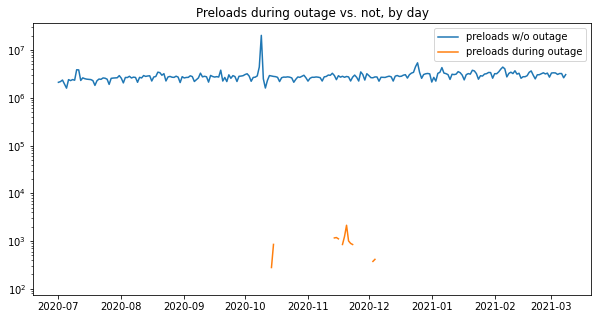

In [352]:
drops_by_date = df_by_hour.pivot_table(values = 'preloads', index = 'date', columns = 'three_hrs_drop', aggfunc = np.sum)
# drops_by_date.sort_values(True,ascending = False)
# drops_by_date.loc[(drops_by_date.index >= datetime.date(2020,12,27)) & (drops_by_date.index <= datetime.date(2020,12,30))]
plt.figure(figsize = (10,5))
plt.plot(drops_by_date)#.loc[(drops_by_date.index >= datetime.date(2020,12,26)) & (drops_by_date.index <= datetime.date(2020,12,30))])
plt.yscale('log')
plt.legend(['preloads w/o outage','preloads during outage'])
plt.title('Preloads during outage vs. not, by day')

Text(0.5, 1.0, 'Preloads during outage vs. not, by hour')

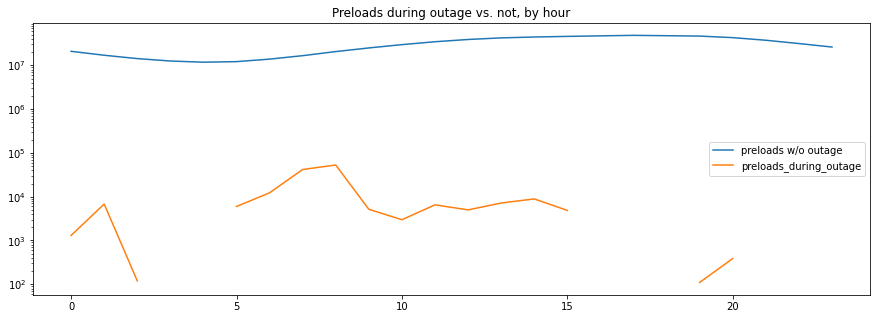

In [207]:
drops_by_hour = df_by_hour.pivot_table(values = 'preloads', index = 'hour', columns = 'three_hrs_drop', aggfunc = np.sum)
plt.figure(figsize = (15,5))
plt.plot(drops_by_hour)
plt.yscale('log') 
plt.legend(['preloads w/o outage','preloads_during_outage'])
plt.title('Preloads during outage vs. not, by hour')

In [357]:
by_advertiser = df_by_hour.pivot_table(values = 'hour', index = 'advertiser_name', columns = 'three_hrs_drop', aggfunc = 'count')
by_advertiser.sort_values(True,ascending = False).head(10)

three_hrs_drop                    False  True 
advertiser_name                               
CMI                              2111.0   22.0
Uber BV                         10214.0   12.0
Trell Experiences                2566.0   11.0
Amanotes Pte. Ltd.              51903.0   10.0
Ilyon Dynamics                  57248.0    9.0
Azur Interactive Games Limited  59293.0    6.0
Ventes Avenues                   9474.0    4.0
Mohalla Tech Pvt Ltd             9848.0    4.0
King.com                        17234.0    3.0
AppSamurai                      15165.0    3.0

<AxesSubplot:xlabel='hour'>

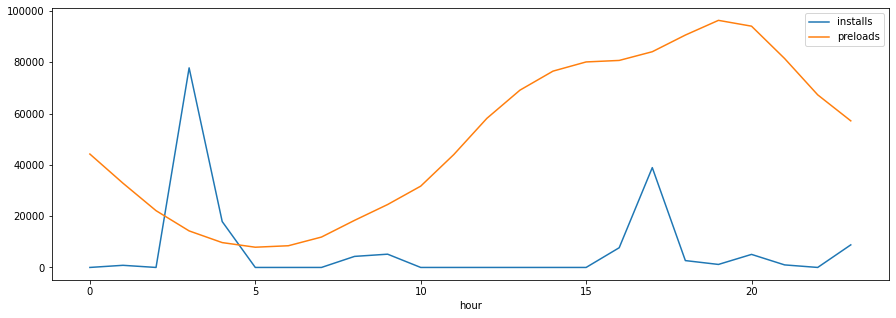

In [371]:
filter = (df_by_hour.advertiser_name == 'CMI') & (df_by_hour.app_identifier == 'com.amazon.mShop.android.shopping') & (df_by_hour.date >= datetime.date(2020,11,1)) & (df_by_hour.date <= datetime.date(2020,11,30))
filtered_by_hour = df_by_hour[filter].pivot_table(values = ['preloads','installs'], index = ['hour'], aggfunc = np.sum)
# filtered_by_hour.sort_values(('preloads'), ascending = False).head(30)
filtered_by_hour.plot(figsize=(15,5))#, ylim = [0,10000])
#plt.yscale('log')


<AxesSubplot:xlabel='date,hour'>

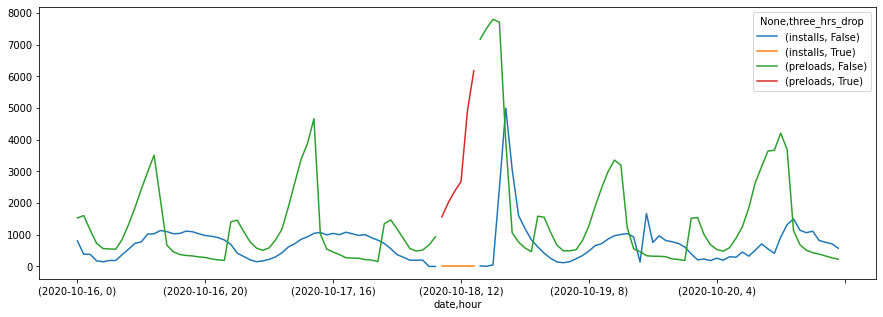

In [378]:
filter = (df_by_hour.advertiser_name == 'Uber BV') & (df_by_hour.app_identifier == 'com.ubercab') & (df_by_hour.date >= datetime.date(2020,10,16)) & (df_by_hour.date <= datetime.date(2020,10,20))
filtered_by_hour = df_by_hour[filter].pivot_table(values = ['preloads','installs'], index = ['date','hour'], columns = 'three_hrs_drop', aggfunc = np.sum)
filtered_by_hour.plot(figsize=(15,5))
# filtered_by_hour.sort_values(('preloads',True), ascending=False).head(30)


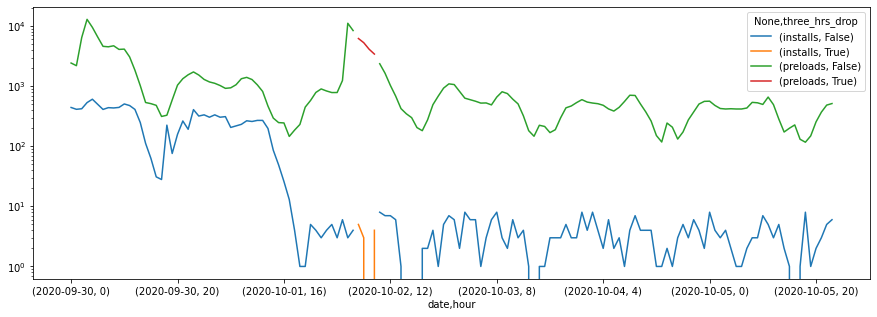

In [382]:
filter = (df_by_hour.advertiser_name == 'Trell Experiences') & (df_by_hour.app_identifier == 'app.trell') & (df_by_hour.date >= datetime.date(2020,9,30)) & (df_by_hour.date <= datetime.date(2020,10,5))
filtered_by_hour = df_by_hour[filter].pivot_table(values = ['preloads','installs'], index = ['date','hour'], columns = 'three_hrs_drop', aggfunc = np.sum)
filtered_by_hour.plot(figsize=(15,5))
plt.yscale('log')
# filtered_by_hour.sort_values(('preloads',True), ascending=False).head(30)


<AxesSubplot:xlabel='date,hour'>

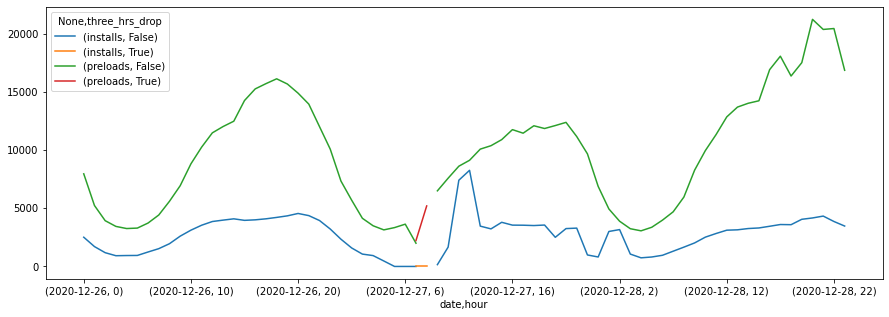

In [395]:
filter = (df_by_hour.advertiser_name == 'Amanotes Pte. Ltd.') & (df_by_hour.app_identifier.isin(['com.amanotes.beathopper','com.amanotes.pamacolorhop','com.amanotes.pamadancingroad','com.amanotes.pamainfinitybounce','com.amanotes.pamarollingtiles2','com.youmusic.magictiles'])) & (
    df_by_hour.date >= datetime.date(2020,12,26)) & (df_by_hour.date <= datetime.date(2020,12,28))
filtered_by_hour = df_by_hour[filter].pivot_table(values = ['preloads','installs'], index = ['date','hour'], columns = 'three_hrs_drop', aggfunc = np.sum)
filtered_by_hour.plot(figsize=(15,5))
# filtered_by_hour.sort_values(('preloads',True), ascending=False).head(30)


<AxesSubplot:xlabel='date,hour'>

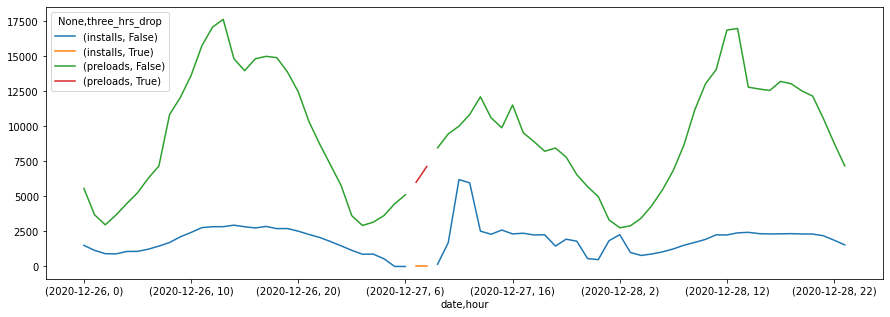

In [312]:
filter = (df_by_hour.advertiser_name == 'Wish') & (df_by_hour.date >= datetime.date(2020,12,26)) & (df_by_hour.date <= datetime.date(2020,12,28))
filtered_by_hour = df_by_hour[filter].pivot_table(values = ['preloads','installs'], index = ['date','hour'], columns = 'three_hrs_drop', aggfunc = np.sum)
filtered_by_hour.plot(figsize=(15,5))
# filtered_by_hour.sort_values(('preloads',True), ascending=False).head(30)


<AxesSubplot:xlabel='date,hour'>

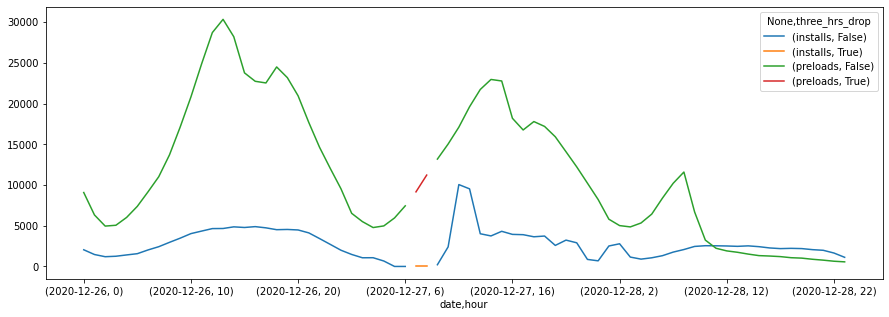

In [323]:
filter = (df_by_hour.advertiser_name == 'King.com') & (df_by_hour.app_identifier == 'com.king.candycrushsaga') & (df_by_hour.date >= datetime.date(2020,12,26)) & (df_by_hour.date <= datetime.date(2020,12,28))
filtered_by_hour = df_by_hour[filter].pivot_table(values = ['preloads','installs'], index = ['date','hour'], columns = ['three_hrs_drop'], aggfunc = np.sum)
filtered_by_hour.plot(figsize=(15,5))
# filtered_by_hour.sort_values(('preloads',True), ascending=False).head(30)


<AxesSubplot:xlabel='date,hour'>

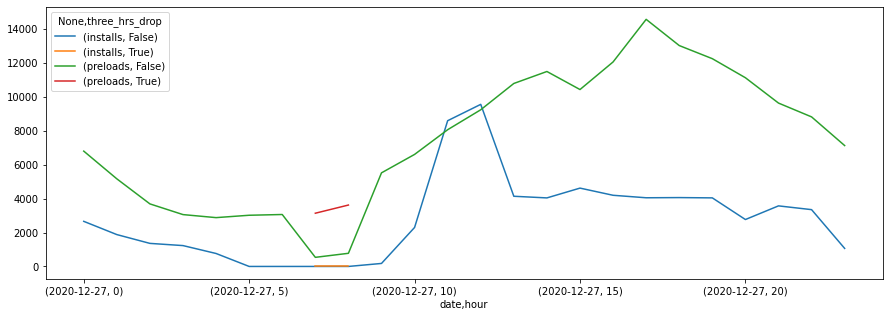

In [347]:
filter = (df_by_hour.advertiser_name == 'Azur Interactive Games Limited') & (df_by_hour.date >= datetime.date(2020,12,27)) & (df_by_hour.date <= datetime.date(2020,12,27))
filtered_by_hour = df_by_hour[filter].pivot_table(values = ['preloads','installs'], index = ['date','hour'], columns = ['three_hrs_drop'], aggfunc = np.sum)
filtered_by_hour.plot(figsize=(15,5))
# filtered_by_hour.sort_values(('preloads',True), ascending=False).head(30)


<AxesSubplot:xlabel='date,hour'>

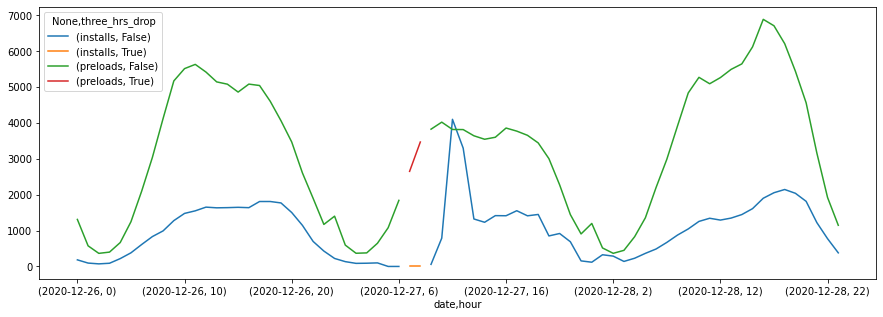

In [349]:
filter = (df_by_hour.advertiser_name == 'TikTok- BR') & (df_by_hour.date >= datetime.date(2020,12,26)) & (df_by_hour.date <= datetime.date(2020,12,28))
filtered_by_hour = df_by_hour[filter].pivot_table(values = ['preloads','installs'], index = ['date','hour'], columns = ['three_hrs_drop'], aggfunc = np.sum)
filtered_by_hour.plot(figsize=(15,5))
# filtered_by_hour.sort_values(('preloads',True), ascending=False).head(30)
